In [1]:
from openai import OpenAI
import os
from dotenv import load_dotenv

load_dotenv()

openai = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

response = openai.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": "You are a comic book creator. Generate a 3-5 page comic based on the user's prompt. Format the response as a JSON object with 'pages' array where each page has 'scene' and 'dialogue'."},
                {"role": "user", "content": "A superhero cat saving the city from evil vacuum cleaners."},
            ],
            response_format={"type": "json_object"}  # ✅ FIXED: Correct format
        )

comic_data = response.choices[0].message.content

In [14]:
comic_data

'{\n  "pages": [\n    {\n      "scene": "Scene 1: Nighttime in the bustling city of Whiskerton. The skyline is illuminated by the moon, and the streets are filled with people and cars. Suddenly, a fleet of evil vacuum cleaners start terrorizing the city, sucking up important landmarks and causing chaos.",\n      "dialogue": [\n        {\n          "character": "Pedestrian 1",\n          "line": "What\'s happening?! Those vacuums are alive!"\n        },\n        {\n          "character": "Pedestrian 2",\n          "line": "Run for your lives! They’re destroying everything!"\n        },\n        {\n          "character": "Narrator",\n          "line": "Meanwhile, in a quiet alleyway, a determined hero sleeps."\n        }\n      ]\n    },\n    {\n      "scene": "Scene 2: Inside the alleyway, a close-up of a tabby cat, known as Captain Whiskers, waking up. He looks directly at the reader, fierce and ready. His cape flutters even though there\'s no wind.",\n      "dialogue": [\n        {\n 

In [19]:
import json
a = json.loads(comic_data)['pages']
a 

[{'scene': 'Scene 1: Nighttime in the bustling city of Whiskerton. The skyline is illuminated by the moon, and the streets are filled with people and cars. Suddenly, a fleet of evil vacuum cleaners start terrorizing the city, sucking up important landmarks and causing chaos.',
  'dialogue': [{'character': 'Pedestrian 1',
    'line': "What's happening?! Those vacuums are alive!"},
   {'character': 'Pedestrian 2',
    'line': 'Run for your lives! They’re destroying everything!'},
   {'character': 'Narrator',
    'line': 'Meanwhile, in a quiet alleyway, a determined hero sleeps.'}]},
 {'scene': "Scene 2: Inside the alleyway, a close-up of a tabby cat, known as Captain Whiskers, waking up. He looks directly at the reader, fierce and ready. His cape flutters even though there's no wind.",
  'dialogue': [{'character': 'Captain Whiskers',
    'line': 'The city needs me. Time to spring into action!'}]},
 {'scene': 'Scene 3: Captain Whiskers darts through alleyways and leaps across rooftops wit

In [ ]:
json.dumps(comic_data)

SyntaxError: unmatched ']' (1166750933.py, line 1)

In [12]:
a['pages']

[{'scene': 'Scene 1: Nighttime in the bustling city of Whiskerton. The skyline is illuminated by the moon, and the streets are filled with people and cars. Suddenly, a fleet of evil vacuum cleaners start terrorizing the city, sucking up important landmarks and causing chaos.',
  'dialogue': [{'character': 'Pedestrian 1',
    'line': "What's happening?! Those vacuums are alive!"},
   {'character': 'Pedestrian 2',
    'line': 'Run for your lives! They’re destroying everything!'},
   {'character': 'Narrator',
    'line': 'Meanwhile, in a quiet alleyway, a determined hero sleeps.'}]},
 {'scene': "Scene 2: Inside the alleyway, a close-up of a tabby cat, known as Captain Whiskers, waking up. He looks directly at the reader, fierce and ready. His cape flutters even though there's no wind.",
  'dialogue': [{'character': 'Captain Whiskers',
    'line': 'The city needs me. Time to spring into action!'}]},
 {'scene': 'Scene 3: Captain Whiskers darts through alleyways and leaps across rooftops wit

In [20]:
from pydantic import BaseModel
from typing import List
# Define the expected schema
class DialogueEntry(BaseModel):
    character: str
    text: str

class ComicPage(BaseModel):
    scene: str
    dialogue: List[DialogueEntry]  # List of dialogues

class ComicScript(BaseModel):
    pages: List[ComicPage]  # A list of pages


completion = openai.beta.chat.completions.parse(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": "You are a professional comic book creator. Generate a detailed 3-5 page comic script based on the user's prompt. The response must be a JSON object following this structure:\n"
                                            "- 'pages': A list of pages.\n"
                                            "- Each page includes:\n"
                                            "  - 'scene': A vivid description of the visual setting.\n"
                                            "  - 'dialogue': A list of dictionaries where each dictionary contains 'character' and 'text' fields.\n"
                                            "Ensure a coherent storyline across pages."},
                {"role": "user", "content": 'a cat'}, #"A cyberpunk detective is investigating a missing android in a neon-lit city."
            ],
            response_format=ComicScript,  # Structured Pydantic validation
        )

# Access the structured response
comic_data = completion.choices[0].message.parsed


In [21]:
new_comic = comic_data.pages

In [ ]:
[page.model_dump() for page in comic_data.pages]

AttributeError: 'list' object has no attribute 'model_dump'

In [35]:
type(comic_data.model_dump()['pages'])

list

In [52]:
from together import Together
import uuid
import datetime
import os
import io
from google import genai
from google.genai import types
from google.cloud import storage
import base64
import concurrent.futures

executor = concurrent.futures.ThreadPoolExecutor(max_workers=5)

client_gemini = genai.Client(
    vertexai=True,
    project="thematic-land-451915-j3",
    location="us-central1",
)

def generate_image_gemini(prompt):
    """Generate an image using the Gemini AI API and return base64."""
    try:
        response = client_gemini.models.generate_images(
            model='imagen-3.0-generate-002',
            prompt=prompt,
            config=types.GenerateImagesConfig(
                number_of_images=1,
                aspect_ratio="3:4",
            )
        )

        generated_image = response.generated_images[0]
        image_bytes = generated_image.image.image_bytes
        base64_encoded = base64.b64encode(image_bytes).decode("utf-8")
        return base64_encoded
    except Exception as e:
        import traceback
        print(f"Error in generate_image_gemini: {e}")
        traceback.print_exc()
        return None

def create_google_cloud_storage_url(base64_image, filename, bucket_name="bucket_comic"):
    """Uploads base64 image to Google Cloud Storage and returns a public URL."""
    try:
        client = storage.Client()
        bucket = client.bucket(bucket_name)
        blob = bucket.blob(filename)

        image_bytes = base64.b64decode(base64_image)
        blob.upload_from_file(io.BytesIO(image_bytes), content_type="image/png")

        # Since the bucket is public, we can directly get the public URL
        return blob.public_url
    except Exception as e:
        import traceback
        print(f"Error in create_google_cloud_storage_url: {e}")
        traceback.print_exc()
        return None

def generate_and_upload(prompt, prefix="gemini_image_", bucket_name="bucket_comic"):
    """Combines image generation and uploading to GCS with auto-generated filename."""
    try:
        base64_image = generate_image_gemini(prompt)
        if base64_image is None:
            print(f"generate_image_gemini returned None for prompt: {prompt}")
            return None

        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        unique_id = uuid.uuid4().hex[:8]
        filename = f"{prefix}{timestamp}_{unique_id}.png"

        url = create_google_cloud_storage_url(base64_image, filename, bucket_name)
        if url is None:
            print(f"create_google_cloud_storage_url returned None for filename: {filename}")
            return None
        return url
    except Exception as e:
        import traceback
        print(f"Error in generate_and_upload: {e}")
        traceback.print_exc()
        return None

bucket_name = "bucket_comic"
prefix = "gemini_image_"

comic_list = [
    {
        "scene": "A sunny urban neighborhood with bustling streets. The focus is on a cozy little apartment balcony adorned with potted plants and a comfy chair. A woman, LISA, is lounging with a cup of coffee, and her orange tabby cat, WHISKERS, perches on the balcony railing.",
        "dialogue": [
            {"Lisa": "Ah, Whiskers, what a gorgeous day! Perfect for just doing nothing, don't you think?"},
            {"Whiskers": "*purrs contentedly*"},
            {"Lisa": "You're really a lucky charm, aren't you? Ever since you came into my life, things have been purrfect."},
        ],
    },
    {
        "scene": "Flashback to the day Lisa found Whiskers. A rainy street, and Lisa, holding an umbrella, bends down to find a drenched and shivering Whiskers hiding under a parked car.",
        "dialogue": [
            {"Lisa": "Oh, you poor thing! Let's get you out of the rain, little buddy."},
            {"Whiskers": "*meows softly*"},
            {"Narration": "That rainy day marked the beginning of their newfound friendship."},
        ],
    },
    {
        "scene": "Back to the present, the afternoon sun casts warm light on the balcony. Whiskers jumps down and nudges Lisa's hand, prompting her to set down her coffee cup.",
        "dialogue": [
            {"Lisa": "Okay, okay! I get it, playtime it is! Who could resist such a cute face?"},
            {"Whiskers": "*rolls playfully on the floor*"},
            {"Lisa": "You know, Whiskers, if only everyone realized how wonderful having a kitty like you is. You've brought so much joy."},
        ],
    },
    {
        "scene": "A montage of Lisa and Whiskers sharing daily activities: Lisa working on her laptop with Whiskers on her lap, playing with a string, napping together, and finally, Whiskers watching the sunset from the window ledge.",
        "dialogue": [
            {"Narration": "In every little moment, Whiskers adds a sprinkle of magic to Lisa's world."},
            {"Lisa": "To another day full of surprises and cat naps, my dear Whiskers. Here's to our adventures!"},
        ],
    },
    {
        "scene": "The final panel shows Lisa and Whiskers dozing peacefully on the chair, the sun setting in the background, casting long shadows.",
        "dialogue": [{"Narration": "Sometimes, the simplest moments bring the greatest happiness. For Lisa, it was finding a nice cat named Whiskers."}],
    },
]

for scene in comic_list:
    url = generate_and_upload(scene["scene"], prefix, bucket_name)
    scene["image_url"] = url
    print(f"Scene: {scene['scene']}, URL: {url}")

Scene: A sunny urban neighborhood with bustling streets. The focus is on a cozy little apartment balcony adorned with potted plants and a comfy chair. A woman, LISA, is lounging with a cup of coffee, and her orange tabby cat, WHISKERS, perches on the balcony railing., URL: https://storage.googleapis.com/bucket_comic/gemini_image_20250227_005450_58dc497b.png
Scene: Flashback to the day Lisa found Whiskers. A rainy street, and Lisa, holding an umbrella, bends down to find a drenched and shivering Whiskers hiding under a parked car., URL: https://storage.googleapis.com/bucket_comic/gemini_image_20250227_005506_e63b6c3e.png
Scene: Back to the present, the afternoon sun casts warm light on the balcony. Whiskers jumps down and nudges Lisa's hand, prompting her to set down her coffee cup., URL: https://storage.googleapis.com/bucket_comic/gemini_image_20250227_005521_44be5b44.png
Scene: A montage of Lisa and Whiskers sharing daily activities: Lisa working on her laptop with Whiskers on her lap

In [ ]:
from google import genai
from google.genai import types
import base64


def generate():
  client = genai.Client(
      vertexai=True,
      project="thematic-land-451915-j3",
      location="us-central1",
  )


  model = "gemini-2.0-flash-001"
  contents = [
    types.Content(
      role="user",
      parts=[
        types.Part.from_text(text="""meaning of life""")
      ]
    )
  ]
  generate_content_config = types.GenerateContentConfig(
    temperature = 1,
    top_p = 0.95,
    max_output_tokens = 8192,
    response_modalities = ["TEXT"],
  )

  for chunk in client.models.generate_content_stream(
    model = model,
    contents = contents,
    config = generate_content_config,
    ):
    print(chunk.text, end="")

generate()

python(99712) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Ah, the Big Question! The meaning of life is one of those things that philosophers, theologians, artists, and ordinary people have pondered for centuries. There's no single, universally accepted answer, which can be both frustrating and liberating.

Here's a breakdown of different perspectives:

**1. Nihilism:**

*   **Core Idea:** Life is inherently without meaning, purpose, or intrinsic value. There's no objective reason for our existence.
*   **Implications:** This can be bleak, but also empowering. If there's no inherent meaning, you're free to create your own.

**2. Existentialism:**

*   **Core Idea:** Meaning is not pre-ordained but created through individual choices and actions. We are "condemned to be free" and responsible for defining our own essence.
*   **Key Concepts:** Authenticity, freedom, responsibility, and the acceptance of the absurdity of existence.
*   **Thinkers:** Jean-Paul Sartre, Albert Camus, Simone de Beauvoir.
*   **Implications:** You are in charge of crea

In [1]:
# import IPython

# app = IPython.Application.instance()
# app.kernel.do_shutdown(True)

In [3]:
import typing
import IPython.display
from PIL import Image as PIL_Image
from PIL import ImageOps as PIL_ImageOps

def display_image(
    image,
    max_width: int = 600,
    max_height: int = 350,
) -> None:
    pil_image = typing.cast(PIL_Image.Image, image._pil_image)
    if pil_image.mode != "RGB":
        # RGB is supported by all Jupyter environments (e.g. RGBA is not yet)
        pil_image = pil_image.convert("RGB")
    image_width, image_height = pil_image.size
    if max_width < image_width or max_height < image_height:
        # Resize to display a smaller notebook image
        pil_image = PIL_ImageOps.contain(pil_image, (max_width, max_height))
    IPython.display.display(pil_image)

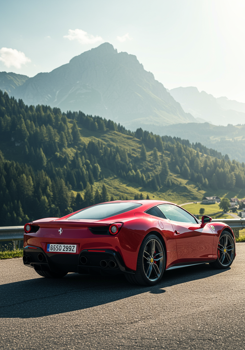

In [4]:
from vertexai.preview.vision_models import ImageGenerationModel
import vertexai

vertexai.init(project="thematic-land-451915-j3", location="asia-southeast1")

generation_model = ImageGenerationModel.from_pretrained("imagen-3.0-generate-002")

images = generation_model.generate_images(
    prompt="a great car",
    number_of_images=1,
    aspect_ratio="3:4",
    negative_prompt="",
    person_generation="",
    safety_filter_level="",
    add_watermark=True,
)

display_image(images[0])



In [ ]:
display_image(images[0])